# Description

Notebook 2/2 du groupe 6 (Achille, Benjamin, Chedha, Hubert, Victor)

**2_Churn_features** est un notebook qui entraine un modèle de machine learning pour prévenir le risque qu'un client soit un churner à partir de son comportement passé.

### Labélisation d'un churner

Il existe de nombreuses façons de définir un churner, nous avons pris l'une d'entre elles qui nous paraissait judicieuse pour notre dataset: Il s'agit de signaler un client comme churner si le nombre de jours écoulés depuis son dernier achat est supérieur à la différence du temps maximal entre ses achats précédents.

Cette définition permet d'éviter de compter comme faux positifs tous nos clients dès qu'il y a des périodes de vacances ou des périodes de creux temporaires dans leur activité.

### Entrainement du modèle

Nous nous servons des 3 derniers mois de transaction pour vérifier si certains clients ont effectivement churnés en appliquant notre règle de churn sur des données futures. Nous avons choisi 3 mois car 95% des clients ont une fréquence d'achat inférieure à 3 mois.

Chaque client est alors caractérisé par un vecteur qui contient un résumé compact des transactions qu'il a réalisé avant les trois derniers mois. **Aucune donnée temporelle fixe n'est donnée au modèle, tous les achats ont des informations temporelles relatives entre eux**. Ainsi, un client ayant churné depuis plus d'un an et un client venant juste de churner sont aussi difficile à entrainer pour le modèle car l'information temporelle fixe est cachée. Cela permet de forcer le modèle à détecter les caractéristiques clefs responsables du churn sans apprendre bêtement que, si la date du dernier achat d'un client est supérieure à 4 mois, alors il est churner. Dans les cas faciles, simplement appliquer la règle du churn par rapport à la date du jour actuel est suffisant.

### Utilisation

Pour un client donné, en fonction de la date du jour, il est possible de savoir s'il est churner en utilisant la règle du churn.
- Si le client est churner, c'est un peu tard pour faire une action commerciale pour le récupérer.
- Si le client n'est a priori pas churner, on applique notre modèle de machine learning pour analyser son comportement d'achat passé et prédire si ce comportement va l'amenner à churner à son prochain achat ou non. Dans le cas où la probabilité de churn est élevée, il est possible de faire une action commerciale ou marketing pour espérer ne pas perdre ce client.

### Résultats:

Notre modèle a un F-1 score de 75%, 77% des clients prédit churner étaient effectivement churner (précision), et 72% des churners ont été repérés (recall). 

En 2 ans, **notre modèle aurait repéré 40000 des 56000 churners**. En supposant que la moitié d'entre eux auraient rachetés grace à des actions commerciales nous aurions gagné **150 millions d'euros**.



# Analyse des paniers

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.distributions.empirical_distribution import ECDF

data = pd.read_csv('panier_client_full.csv', parse_dates = ['date_order']).rename(columns = {'delay_bool': 'delay_number'})

In [2]:
data['delay_mean'] = data['delay_mean'].replace({0: np.NaN})
data['delay_max'] = data['delay_max'].replace({0: np.NaN})
data['delay_bool'] = data['delay_number'] > 0
data.head()

,client_id,date_order,sales_net,quantity,number_of_products,delay_mean,delay_max,delay_number,channel,delay_bool
0,6.0,2017-11-29,204.12961,8.0,2.0,NaN,NaN,0.0,at the store,False
1,6.0,2018-11-20,270.80200,20.0,4.0,NaN,NaN,0.0,at the store,False
2,6.0,2018-11-22,193.42080,3.0,1.0,NaN,NaN,0.0,at the store,False
3,6.0,2019-02-12,139.24200,3.0,1.0,NaN,NaN,0.0,at the store,False
4,6.0,2019-02-13,35.13480,6.0,2.0,NaN,NaN,0.0,at the store,False


# Labelisation des churners

## Utils

In [3]:
#Détermination de la date de dernier achat au jour près
def last_buy_days(data, ref_date=None):
    if ref_date is None:
        ref_date = datetime.datetime(2019, 9, 22)
    df = data.groupby('client_id').agg({'date_order' : 'max'}).rename(columns = {'date_order' : 'last_buy'})
    df['recency'] = (ref_date - df.last_buy).map(lambda x: x.days)
    return df

In [4]:
def feature_engineering_nonagg(data):
    #Détermination de la durée entre deux achats et de l'évolution du panier
    data['diff_previous_buy_days'] = data.sort_values(by = ['client_id', 'date_order']).groupby('client_id').date_order.diff().map(lambda x: x.days)
    data['diff_previous_buy_sales'] = data.sort_values(by = ['client_id', 'date_order']).groupby('client_id').sales_net.diff()
    return data

In [5]:
def consumption(data):
    #Détermination du comportement d'un client
    consumption = data.groupby('client_id').agg({'diff_previous_buy_days' : ['mean', 'std', 'min', 'max'], 'diff_previous_buy_sales' : ['mean', 'std', 'min', 'max']})
    consumption.columns = list(map(lambda x: '_'.join(x), consumption.columns.values))
    return consumption

In [6]:
def labelling(client, data_source, ref_date=datetime.datetime(2019, 9, 22)):
    #Labelisation des données suivant la règle recency > max difference entre 2 achats
    client['recency'] = last_buy_days(data_source, ref_date).recency
    client['y_churner'] = (client.recency > client.diff_previous_buy_days_max)
    return client

In [7]:
def feature_eng(data, label = True):
    #Détermination du comportement d'un client
    consum = consumption(data)
    
    #Analyse de la valeur par channel (€ et nombre de paniers)
    client = data.groupby(['client_id', 'channel']).agg({'sales_net' : 'sum', 'quantity' : 'count', 'delay_mean' : 'mean',
                                                         'delay_max' : 'max', 'delay_number' : 'sum', 'delay_bool' : 'sum'}).unstack()
    client.columns = list(map(lambda x: '_'.join(x), client.columns.values))
    
    #Ajout du comportement client
    client = pd.merge(client, consum, how = 'left', left_on = client.index, right_on = consum.index, left_index = True).drop(columns = ['key_0'])
    client['volume'] = data.groupby('client_id').date_order.count()
    client['sales_net'] = data.groupby('client_id').sales_net.sum()
    
    #Calcul de la derniere date d'achat
    if label:
        client = labelling(client, data)
    client.fillna(0, inplace = True)
    
    return client

## Feature engineering sur un subset de date

In [8]:
#Référence 3 mois avant la derniere date dispo
reference_date = datetime.datetime(2019, 6, 22)

#Définition des before
data_before = data[data.date_order < reference_date].copy(deep = True)

In [9]:
data_after = data[data.date_order >= reference_date].copy(deep = True)

In [10]:
#Calcul des features non aggrégées sur le dataframe "before"
df_before = feature_engineering_nonagg(data_before)

In [11]:
#Intermédiaire pour calculer la métrique de churn
max_before = data_before.groupby('client_id').date_order.max()
min_after = data_after.groupby('client_id').date_order.min()

In [12]:
#Estimation des volumes non-notables
communs = pd.merge(min_after, max_before, how = 'inner', left_on = min_after.index, right_on = max_before.index)
nb_conquis = min_after.shape[0] - communs.shape[0]
nb_perdus = max_before.shape[0] - communs.shape[0]
print(f'Nb perdus : {nb_perdus}')
print(f'Nb_conquis : {nb_conquis}')

Nb perdus : 67000
Nb_conquis : 6678


In [13]:
#Calcul des features agregées pour le before et des personnes non-notables pour faible volume
df_before_agg = feature_eng(df_before, label = False)
mask_volume = df_before_agg.volume > 2

In [14]:
print(f'Perte de : {mask_volume.value_counts().iloc[1]}')
df_before_agg = df_before_agg[mask_volume]

Perte de : 33768


In [15]:
#Etape de labelling
threshold = (min_after[max_before.index][mask_volume] - max_before[mask_volume]).map(lambda x : x.days).fillna(np.inf)

target = df_before_agg.diff_previous_buy_days_max < (1.1 * threshold)

In [16]:
target.value_counts(normalize = True)

False    0.563173
True     0.436827
dtype: float64

In [17]:
target.value_counts()

False    73293
True     56850
dtype: int64

In [18]:
#Addition du nombre de produis distinct
product = pd.read_csv('product_client_full.csv').rename(columns = {'quantity' : 'distinct_products'})
product = product.groupby('client_id').distinct_products.sum()

#Addition du nombre de branche distinctes visitées
branch = pd.read_csv('branch_client.csv')
branch = branch.groupby('client_id').quantity.sum()

In [19]:
df_before_agg['distinct_products'] = product

In [20]:
df_before_agg['distinct_branchs'] = branch

# Prediction simple

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [22]:
#Suppression des varaibles prédicitives des données d'entrainement

y = target
X = df_before_agg

X_train, X_test, y_train, y_test = train_test_split(X, y, )

#Pipeline de traitement / Scaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [23]:
#Model
model = LogisticRegression()

In [24]:
#GridSearch
param_grid = {'C': np.logspace(-2, 0, num = 10), 'penalty': ['l2']}
# param_grid = {'n_estimators' : [10, 30, 50, 100], 'subsample' : [0.5, 0.8, 1]}
# param_grid = {'n_estimators' : [10, 30, 50], 'max_depth' : [None, 5, 10]}

gridsearch = GridSearchCV(model, param_grid, scoring = 'roc_auc', verbose = 2, cv = 5)
gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.01, penalty=l2, total=   0.6s
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ............................... C=0.01, penalty=l2, total=   0.6s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.5s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.5s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.4s
[CV] C=0.016681005372000592, penalty=l2 ..............................
[CV] ............... C=0.016681005372000592, penalty=l2, total=   0.4s
[CV] C=0.016681005372000592, penalty=l2 ..............................
[CV] ............... C=0.016681005372000592, penalty=l2, total=   0.4s
[CV] C=0.016681005372000592, penalty=l2 ..............................
[CV] ............... C=0.016681005372000592, penalty=l2, total=   0.8s
[CV] C=0.016681005372000592, penalty=l2 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

              precision    recall  f1-score   support

       False       0.77      0.79      0.78     18270
        True       0.72      0.71      0.71     14266

    accuracy                           0.75     32536
   macro avg       0.75      0.75      0.75     32536
weighted avg       0.75      0.75      0.75     32536



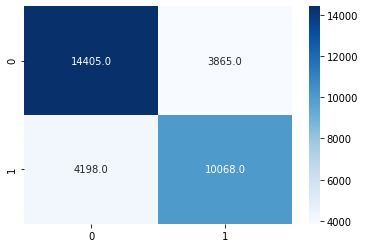

In [25]:
#Best estimateur
best_model = gridsearch.best_estimator_

#Test set
y_pred = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = '.1f', cmap = 'Blues')
plt.show()

              precision    recall  f1-score   support

       False       0.78      0.79      0.78     55023
        True       0.72      0.70      0.71     42584

    accuracy                           0.75     97607
   macro avg       0.75      0.75      0.75     97607
weighted avg       0.75      0.75      0.75     97607



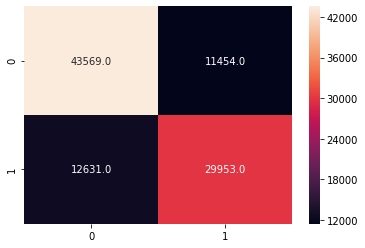

In [26]:
#Train set
y_pred_train = best_model.predict(X_train_scaled)

print(classification_report(y_train, y_pred_train))
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot = True, fmt = '.1f')

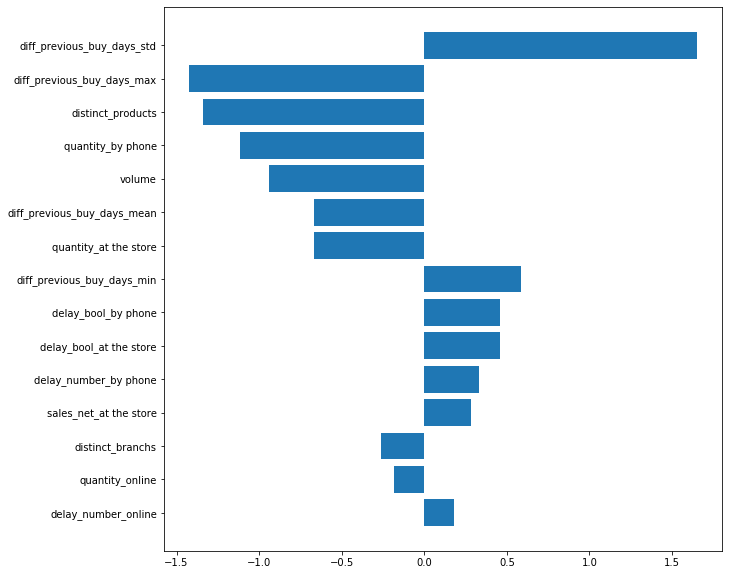

In [27]:
size = best_model.coef_.shape[1]

coef = best_model.coef_.reshape((size,))
val =  np.array(X.columns)

perm = [y for x,y in sorted([(v,i) for i,v in enumerate(abs(coef))])]
                                
                                
# "all_features = sorted(zip(),))
plt.figure(figsize = (10,10))

plt.barh(val[perm][-15:], coef[perm][-15:])
plt.show()

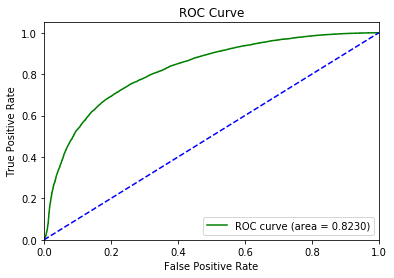

In [28]:
y_probas = best_model.predict_proba(X_test_scaled)

fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## RandomForest

In [29]:
#Model
rf = RandomForestClassifier()
#GridSearch
# param_grid = {'n_estimators' : [10, 30, 50], 'max_depth' : [5, 10, 15]}
param_grid = {'n_estimators' : [50], 'max_depth' : [10, 15, 20], 'criterion' : ['gini', 'entropy'], 'min_samples_leaf' : [3, 5]}

gridsearch_rf = GridSearchCV(rf, param_grid, scoring = 'precision', verbose = 2, cv = 5)
gridsearch_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50, total=   7.3s
[CV] criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50, total=   7.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50, total=   6.9s
[CV] criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50, total=   8.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=3, n_estimators=50, total=   6.8s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5, n_estimators=50 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=5, n_estimators=50, total=   6.8s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5, n_estimators=50 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=5, n_estimators=50, total=   6.5s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5, n_estimators=50 
[CV]  criterion=gini, max_depth=10, min_sample

[CV]  criterion=entropy, max_depth=20, min_samples_leaf=3, n_estimators=50, total=  12.3s
[CV] criterion=entropy, max_depth=20, min_samples_leaf=3, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, min_samples_leaf=3, n_estimators=50, total=  11.6s
[CV] criterion=entropy, max_depth=20, min_samples_leaf=3, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, min_samples_leaf=3, n_estimators=50, total=  11.5s
[CV] criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50, total=  12.0s
[CV] criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50, total=  12.4s
[CV] criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50, total=  11.4s
[CV] criterion=entropy, max_depth=20, min_samples_leaf=5, n_estimators=50 
[CV]  crit

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  9.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

              precision    recall  f1-score   support

       False       0.79      0.84      0.81     18270
        True       0.77      0.71      0.74     14266

    accuracy                           0.78     32536
   macro avg       0.78      0.77      0.78     32536
weighted avg       0.78      0.78      0.78     32536



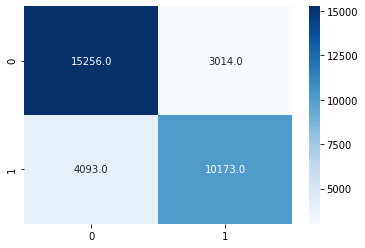

In [30]:
#Best estimateur
best_rf = gridsearch_rf.best_estimator_

#Test set
y_pred_rf = best_rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True, fmt = '.1f', cmap = 'Blues')
plt.show()

In [31]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

       False       0.85      0.89      0.87     55023
        True       0.86      0.80      0.83     42584

    accuracy                           0.85     97607
   macro avg       0.85      0.85      0.85     97607
weighted avg       0.85      0.85      0.85     97607



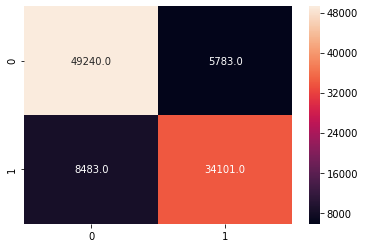

In [32]:
#Train set
y_pred_train_rf = best_rf.predict(X_train_scaled)

print(classification_report(y_train, y_pred_train_rf))
sns.heatmap(confusion_matrix(y_train, y_pred_train_rf), annot = True, fmt = '.1f')

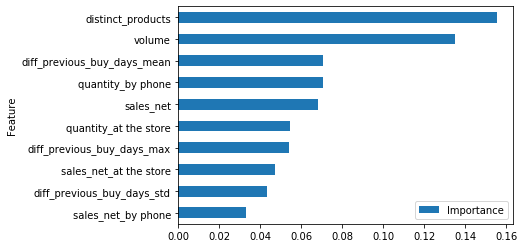

In [33]:
#Importance des variables
feature_importance = pd.DataFrame(index = [i for i in range(len(X_train.columns))])
feature_importance['Feature'] = X_train.columns
feature_importance['Importance'] = best_rf.feature_importances_
feature_importance.set_index('Feature', inplace = True)

feature_importance.sort_values(by = 'Importance').iloc[32:].plot(kind = 'barh')
plt.show()

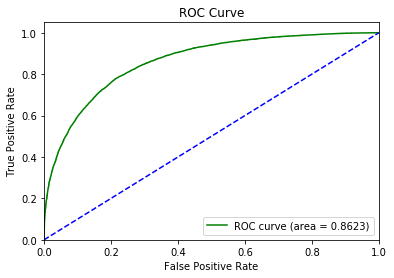

In [34]:
y_probas = best_rf.predict_proba(X_test_scaled)

fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Gain du projets du projets

In [35]:
#Nombre de churners
print('Le nombre de churner est : %.0f'%target.sum())

Le nombre de churner est : 56850


In [36]:
#Nombre de churner identifié
churner_identified = (y_train & y_pred_train).sum() + (y_test & y_pred).sum()
print('Le nombre de churner identifié est : %.0f'%churner_identified.sum())

Le nombre de churner identifié est : 40021


In [37]:
taux_recuperation = 0.5
avoided_churner = churner_identified * taux_recuperation
print('Le nombre de churner identifié est : %.0f'%avoided_churner.sum())

Le nombre de churner identifié est : 20010


In [38]:
#Valeur de CA perdu à cause des churners
revenue_loss = X_train[y_train].sales_net.sum() + X_test[y_test].sales_net.sum()
print('Le revenue perdu total est : %.0f' %revenue_loss)

Le revenue perdu total est : 893351782


In [39]:
revenue_loss_identified = X_train[y_train & y_pred_train].sales_net.sum() + X_test[y_test & y_pred].sales_net.sum()
print('Le revenue perdu identifié est : %.0f' %revenue_loss_identified)

Le revenue perdu identifié est : 277918787


In [40]:
avoided_loss = taux_recuperation * revenue_loss_identified
print('Le revenu gagné est : %.0f' %avoided_loss)

Le revenu gagné est : 138959394


# Comportement des acheteurs sur un subset de durée

## Visualisation du comportement client

In [41]:
data_nonagg = feature_engineering_nonagg(data)
data_nonagg.head()

,client_id,date_order,sales_net,quantity,number_of_products,delay_mean,delay_max,delay_number,channel,delay_bool,diff_previous_buy_days,diff_previous_buy_sales
0,6.0,2017-11-29,204.12961,8.0,2.0,NaN,NaN,0.0,at the store,False,33.0,-1153.96019
1,6.0,2018-11-20,270.80200,20.0,4.0,NaN,NaN,0.0,at the store,False,194.0,-301.67114
2,6.0,2018-11-22,193.42080,3.0,1.0,NaN,NaN,0.0,at the store,False,2.0,-77.38120
3,6.0,2019-02-12,139.24200,3.0,1.0,NaN,NaN,0.0,at the store,False,33.0,-18.42423
4,6.0,2019-02-13,35.13480,6.0,2.0,NaN,NaN,0.0,at the store,False,1.0,-104.10720


In [42]:
df = feature_eng(data_nonagg, label = False)
df = df[df.volume > 2]

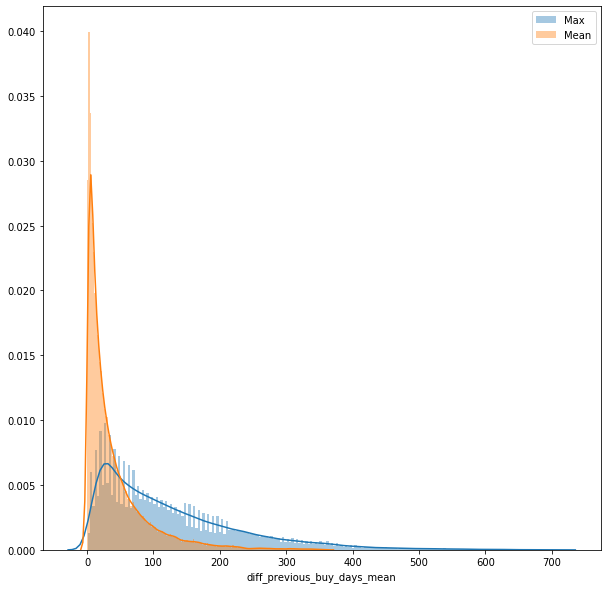

In [43]:
plt.figure(figsize = (10, 10))
sns.distplot(df.diff_previous_buy_days_max, bins = 200, label = 'Max') 
sns.distplot(df.diff_previous_buy_days_mean, bins = 200, label = 'Mean')
plt.legend()
plt.show()

In [44]:
#Fonction de visualisation de la réparition des durée entre 2 achats pour différents clients
#df non aggregated data (vision par panier)
def plot_ecdf(df, n = 6):
    client_id_list = np.random.choice(df.client_id.unique(), size = n)
    for client in client_id_list:
        ecdf = ECDF(df[df.client_id == client].diff_previous_buy_days.fillna(0), side = 'right')
        plt.plot(ecdf.x, ecdf.y, label = int(client))
    plt.xlabel('Durée entre 2 achats')
    plt.ylabel('Fonction de répartition')
    plt.legend()
    plt.show()

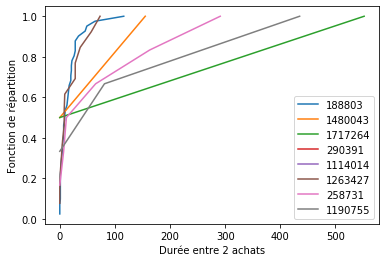

In [45]:
plot_ecdf(data_nonagg, n = 8)